<h1 align="center"><a href="https://github.com/sborquez/volcano-seismic_classifier">Volcano-Seismic Classifier</a> - Automatic classification of seismic signals from Llaima volcano (Chile).</h1>

<center>
<br>
<img align="center" src="images/utfsm.png" width="50%"/>

<h2 align="center">Exploratory Data Analysis</h2>
</center>

<center>
<i> Notebook created by Sebastián Bórquez G. - <a href="mailto://sebstian.borquez@sansano.usm.cl">sebastian.borquez@sansano.usm.cl</a> - utfsm - Jul 2021.</i>
</center>


In [1]:
from extra import *

# Table of Content

* [Problem description](#problem)
* [Llaima volcano dataset](#dataset)
* [Exploratory Data Analysis](#eda)
    * [Class imbalance](#class_imbalance)
    * [Mean signal](#mean)
* [References](#references)

<a id="problem"><a/>

# Problem description 

From [1]:
_Volcanic activity involves physical processes characterized by thetransport of mass and energy, generating specific patterns in the form of discrete land oscillations that are referred to as volcano seismic events. The monitoring of such events produces an ever-growing volume of signals in the form of continuous data streams,thus leading to storage and processing challenges that motivate the design of efficient tools capable of mining meaningful information and detecting implicit pattern._

_The main intent of those tools is to automatically identify volcanic activities in attempt to mitigate, or at least significantly reduce,their economic and social impacts. Especially in countries prone to this type of events like Chile. By modeling seismic patterns we can reveal important information regarding the likelihood, timing, and severity of such activity.

_In addition, the complexity and the time consumed in the signal analysis in conjunction with the high occurrence of events make infeasible the presence of excessive human interventions in such process, motivating automatic approaches to detect and classify volcano-seismic events._

_This is not a trivial task mostly because several external factors such as soil characteristics, site effects where the monitoring station is located at and its source geometry. Such factors may affect event characteristics as, for instance, modifying the signal phases, amplifying or attenuating its amplitudes in specific frequencies and/or introducing delays._

Differents approach of deep learning models were evaluate in [1], using a 10-fold crossvalidation strategy. According to the authors, achieving satifactories results of >90% of accuracy. Nonetheless, 2D-CNN, LSTM and MLP architecture require a timeconsuming preprocessing step. To avoid this step, they propose SeismicNet, an end-to-end 1D-CNN architecture to automatic extraction of signal feautures from the raw signal, demostrating the capacity of automatic feature extraction.

<a id="dataset"><a/>

# Llaima volcano dataset

![LAV station](images/01/llaima.jpg)

The dataset [2] was created from signals collected by monitoring stations located at the Llaima volcano (Chile), at the western edge of the Andes in Araucania Region, Chile (S 38°41′ - W 71°44′). The signals were recorded from the LAV station between 2010 and 2016, sampled at 100Hz and filtered using a 10th-order Butterworth bandpass filter in range 1-10 Hz to preserve the bandwidth that contains the range of interest. After individually processing and analyzing every signal, specialists from the Observatorio Vulcanológico de los Andes Sur (OVDAS) classified them into four class according to their event source:
* __Volcano-Tectonic (VT)__: events associated with brittle failure of rocks inside of the volcanic building, which is the same type of event that happens along purely tectonic faults (e.g. the San Andreas Fault).
* __Long Period (LP)__: events usually observed before volcanic eruptions, being an important indicator of relevant imminent activities.
* __Tremor (TR)__: events that produce continuous and high-amplitude signals originated from several different processes, such as long-lived resonance due to extended flow of magma movement through cracks.
* __Tectonic (TC)__: events are not related to volcanic activities, being a typical result of the dynamics of geological faults.

The dataset is composed of __3592 signals__ separated by class and filtered to select the segment that contains the most representative part of the seismic event. This dataset is important to support researchers interested in studying seismic signals from active volcanoes and developing new methods to model time-dependent data.

<a id="eda"><a/>

# Explotatory Data Analysis

In this section, the data is loaded, and exploration of its content is performed.

In [35]:
dataset_folder = Path('Seimic Events') 

In [36]:
ls "$dataset_folder"

lp.hdf5*  tc.hdf5*  tr.hdf5*  vt.hdf5*


In [497]:
import h5py

def load_file(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]
        # Get the data
        data = np.array(f[a_group_key])
    return data

def show_sample(sample, title=None, center=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))
    plt.suptitle(title, fontsize=24)
    # Time domain
    ax1.set_title("Time Domain", fontsize=16)
    if center:
        ax1.plot(sample - sample[-1])
    else:
        ax1.plot(sample)
    ax1.set_ylabel('Intensity', fontsize=16)
    ax1.set_xlabel('$\Delta t$', fontsize=16)
    ax1.grid(True)
    # Frecuency domain
    ax2.set_title("Spectrogram", fontsize=16)
    samplingFrequency   = 100
    _ = ax2.specgram(sample - sample[-1], Fs=samplingFrequency)
    #_ = ax2.specgram(sample, Fs=samplingFrequency)
    ax2.set_ylabel('Frecuency [hz]', fontsize=16)
    ax2.set_xlabel('Time [s]', fontsize=16)

def show_acf(sample):
    # Display the autocorrelation plot of your time series
    plt.figure(figsize=(24,6))
    fig = tsaplots.plot_acf(sample - sample[-1], lags=200, ax = plt.gca())
    plt.show()
    
def setup_dataset(**classes_data):
    labels = sorted(list(classes_data.keys()))
    X, y = None, None
    for c, label in enumerate(labels):
        X_c = classes_data[label].squeeze().copy()
        X_c[:,:] -= np.expand_dims(X_c[:, -1], -1) 
        y_c = len(X_c)*[c]
        if X is None:
            X, y = X_c, y_c
        else:
            X = np.vstack((X, X_c))
            y = np.hstack((y, y_c))
    return X, y, labels

In [498]:
lp_data = load_file(dataset_folder / 'lp.hdf5')
tc_data = load_file(dataset_folder / 'tc.hdf5')
tr_data = load_file(dataset_folder / 'tr.hdf5')
vt_data = load_file(dataset_folder / 'vt.hdf5')

X, y, labels = setup_dataset(lp=lp_data, tc=tc_data, tr=tr_data, vt=vt_data)

In [499]:
print('lp data shape:', lp_data.shape)
print('tc data shape:', tc_data.shape)
print('tr data shape:', tr_data.shape)
print('vt data shape:', vt_data.shape)

lp data shape: (1310, 6000, 1)
tc data shape: (1488, 6000, 1)
tr data shape: (490, 6000, 1)
vt data shape: (304, 6000, 1)


In [500]:
print('Labels:', labels)
print('X shape:', X.shape)
print('y shape:', y.shape)

Labels: ['lp', 'tc', 'tr', 'vt']
X shape: (3592, 6000)
y shape: (3592,)


### Samples

/opt/conda/envs/rapids/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


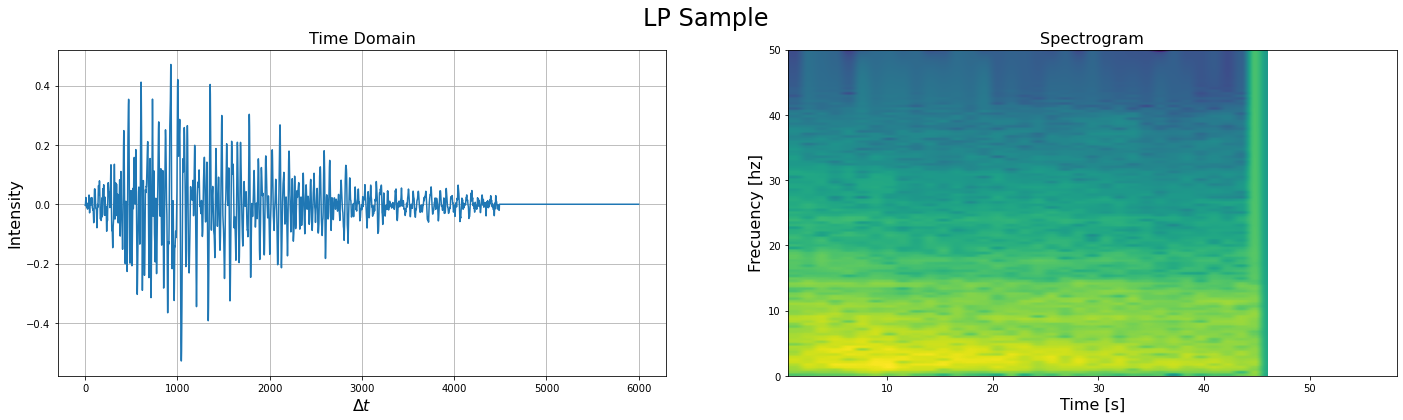

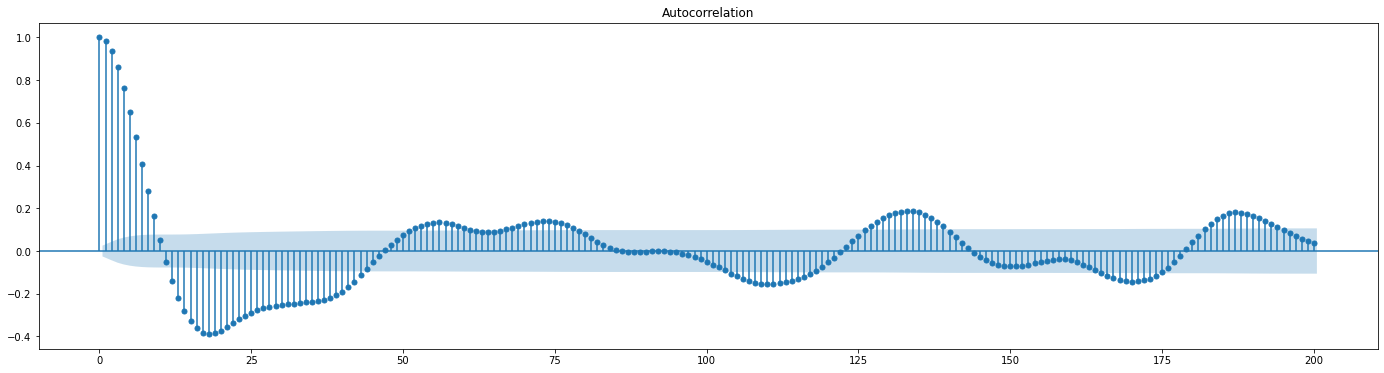

In [501]:
i = np.random.randint(len(lp_data))
sample = lp_data[i].flatten()
show_sample(sample, "LP Sample")
show_acf(sample)

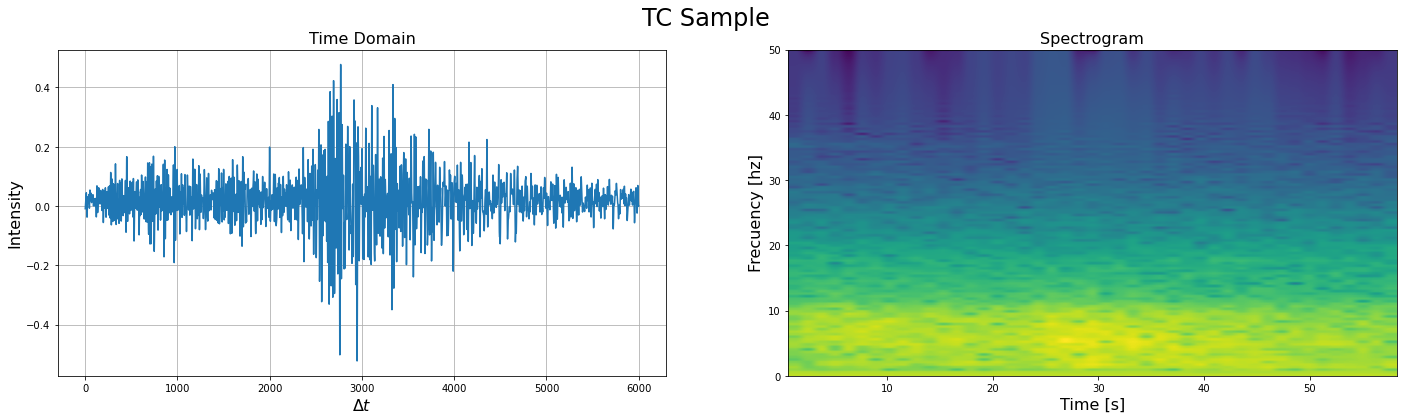

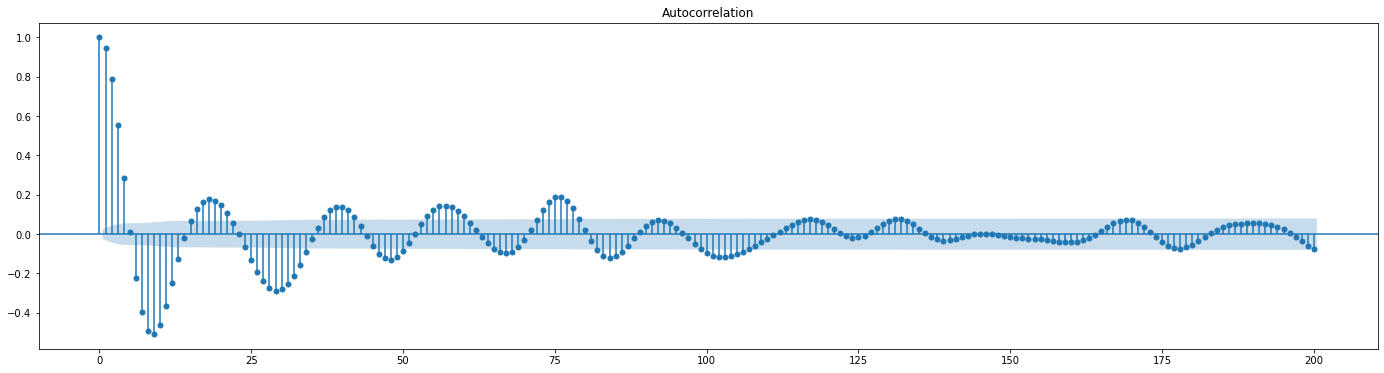

In [502]:
i = np.random.randint(len(tc_data))
sample = tc_data[i].flatten()
show_sample(sample, "TC Sample")
show_acf(sample)

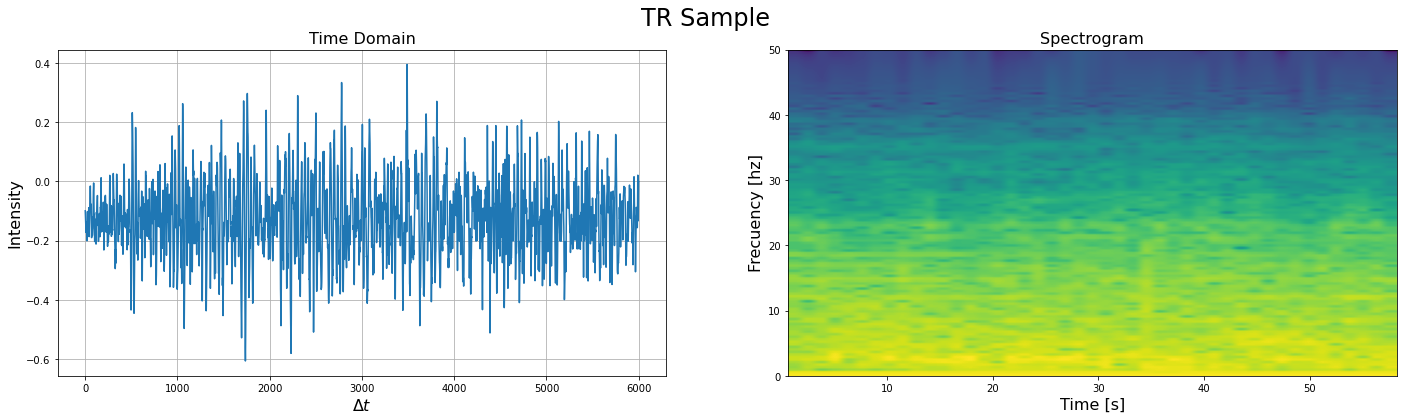

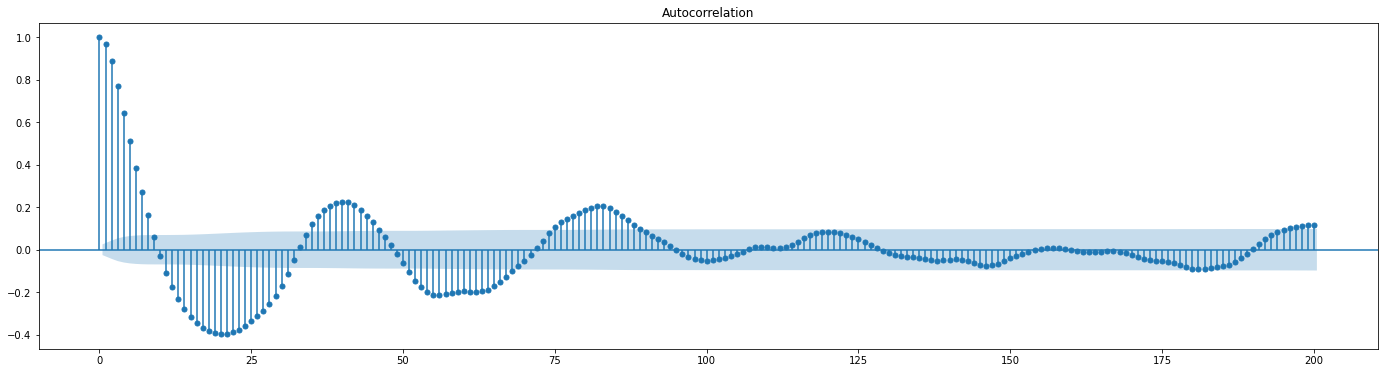

In [503]:
i = np.random.randint(len(tr_data))
sample = tr_data[i].flatten()
show_sample(sample, "TR Sample")
show_acf(sample)

/opt/conda/envs/rapids/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7702: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


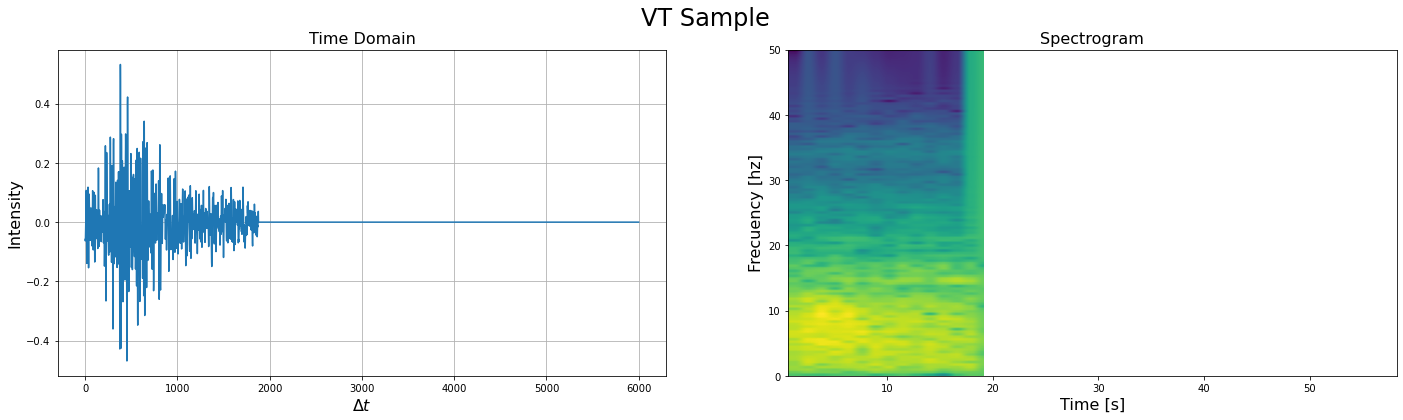

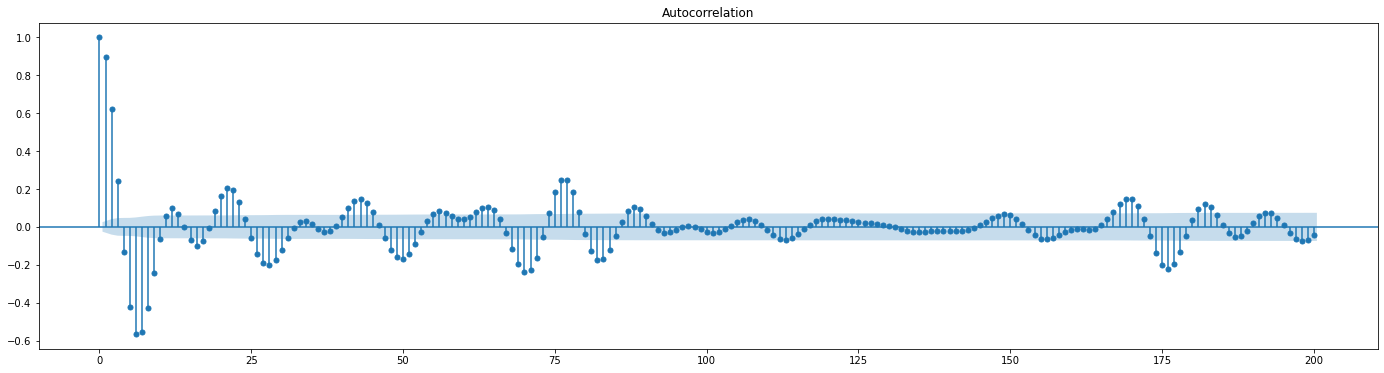

In [504]:
i = np.random.randint(len(vt_data))
sample = vt_data[i].flatten()
show_sample(sample, "VT Sample")
show_acf(sample)

<a id="class_imbalance"><a/>

## Class imbalance

The class distribution is imbalances, due to the natural occurrence of the tremor (TR) and volcanic (VT) events.


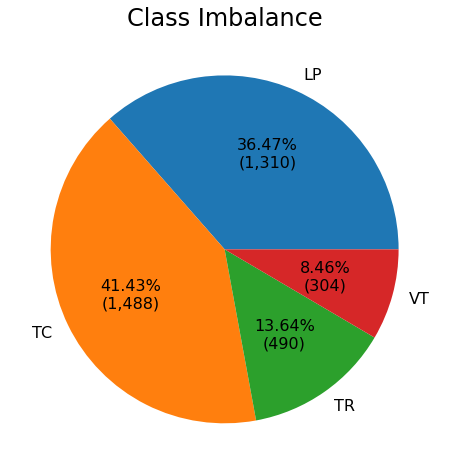

In [495]:
_, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8,8))
plt.title("Class Imbalance", fontsize=24)
plt.pie(counts, 
        labels=list(map(lambda l: l.upper(), labels)), textprops={'fontsize': 16},
        autopct=lambda p : f'{p:.2f}%\n({p*sum(counts)/100:,.0f})');

<a id='mean'><a/>

## Mean Signal

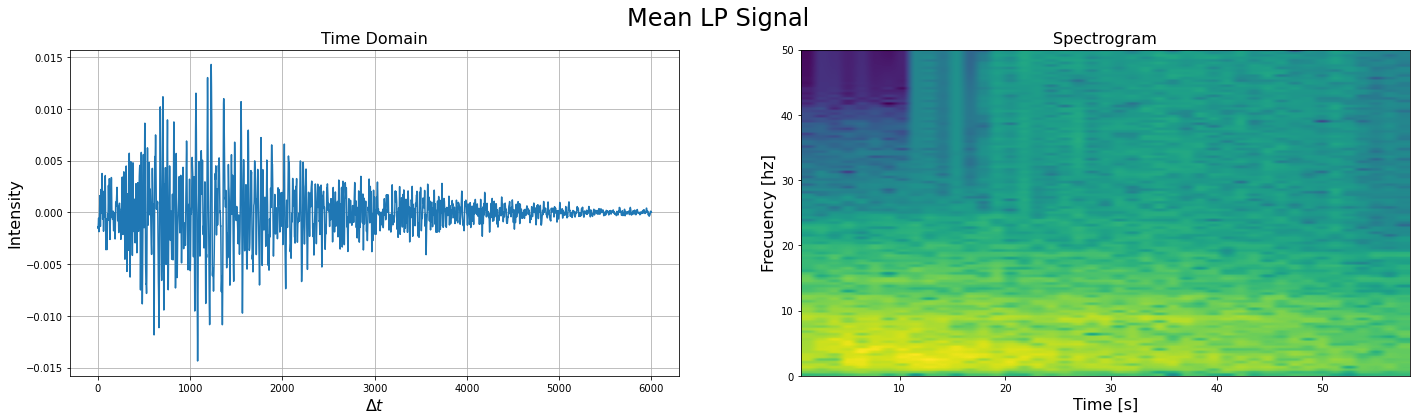

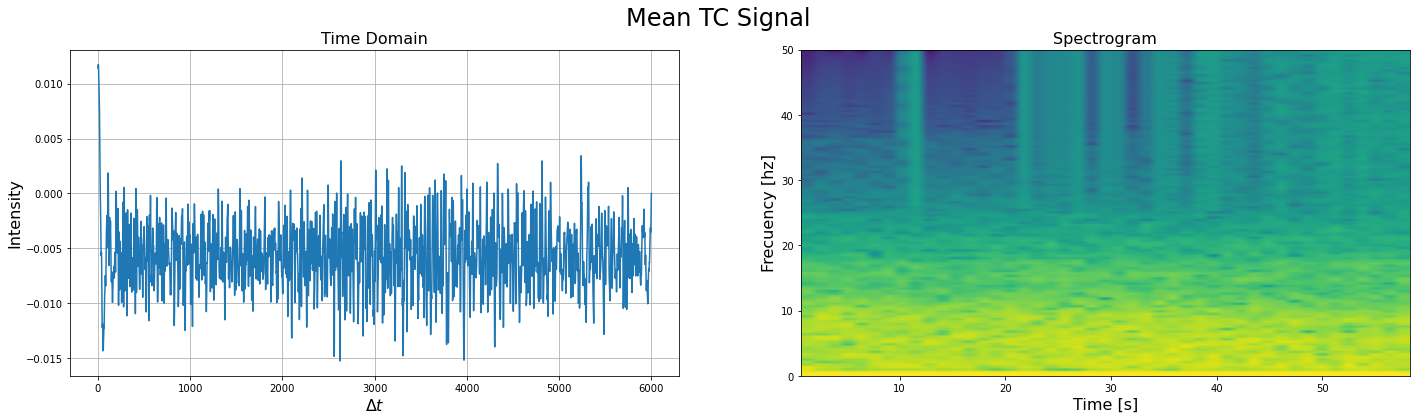

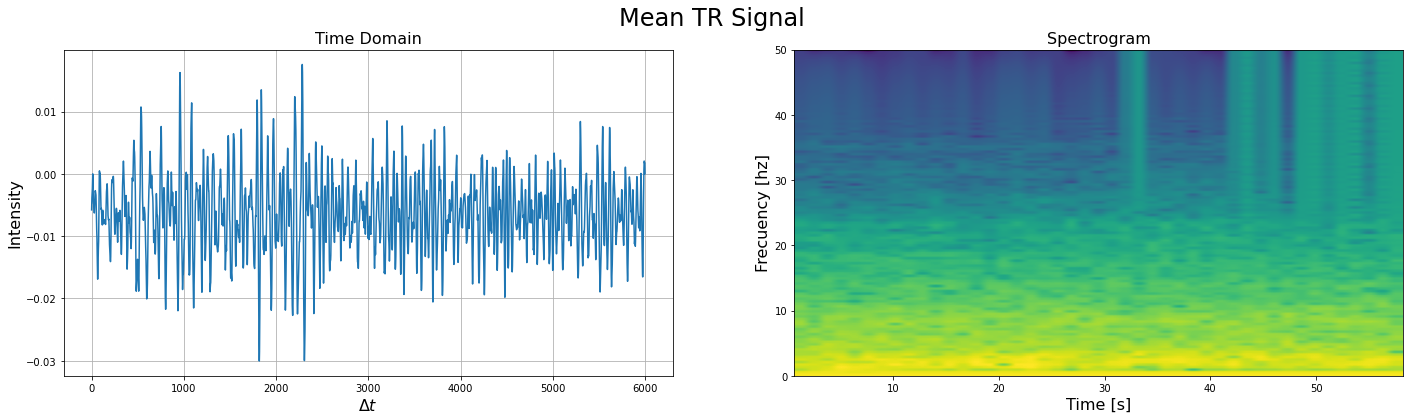

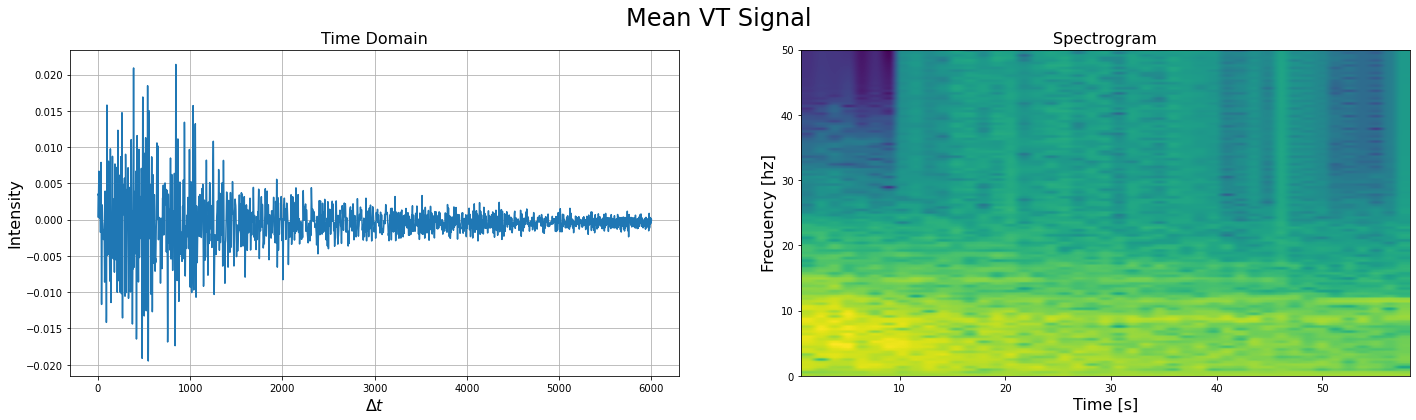

In [496]:
for i, label in enumerate(labels):
    mean_sample = X[y == i].mean(axis=0)
    show_sample(mean_sample, title=f'Mean {label.upper()} Signal', center=False)

<a id="references"><a/>

# References

* [1] In-depth comparison of deep artificial neural network architectures on seismic events classification
* [2] Llaima volcano dataset: In-depth comparison of deep artificial neural network architectures on seismic events classification